In [4]:
import os
from os import listdir
from os.path import isfile, join
from shutil import copy2
#from tqdm import tqdm #pip install tqdm
import progressbar #pip install progressbar2
import tensorflow as tf
import numpy as np
import pandas as pd
import glob,cv2
import sys,argparse
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score

tf.logging.set_verbosity(tf.logging.ERROR)

In [5]:
def predict(filename):
    #filename = dir_path +'/' +image_path
    input_height = 1
    input_width = 20
    num_channels = 1

    mylist = []
    
    tmp_df = pd.read_csv('binary_attr_jarhead.csv')

    #print('Now going to read {} files (Index: {})'.format(fields, index))

    head, tail = os.path.split(filename)
    string_ = tail.split("_")
    #index_list = tmp_df[(tmp_df['file']== (string_[0]+'.jar'))].index.tolist()
    index_list = tmp_df[tmp_df['file'].str.contains(string_[0])==True].index.tolist()

    if not index_list:
        print('Not in jarhead',filename)
        raise SystemExit()
    else:
        mylist.append(((tmp_df.loc[index_list]).iloc[0,1:]).values)

    #The input to the network is of shape [None,input_height,input_width,num_channels]. Hence we reshape.
    row = np.array(mylist)
    x_batch = row[0].reshape(1,input_height,input_width,num_channels)

    image_size=128
    img_num_channels=3
    images = []
    # Reading the image using OpenCV
    image = cv2.imread(filename)
    # Resizing the image to our desired size and preprocessing will be done exactly as done during training
    image = cv2.resize(image, (image_size, image_size),0,0, cv2.INTER_LINEAR)
    images.append(image)
    images = np.array(images, dtype=np.uint8)
    images = images.astype('float32')
    images = np.multiply(images, 1.0/255.0) 
    #The input to the network is of shape [None image_size image_size img_num_channels]. Hence we reshape.
    x_batch_img = images.reshape(1, image_size,image_size,img_num_channels)

    ## Let us restore the saved model
    sess = tf.Session()
    # Step-1: Recreate the network graph. At this step only graph is created.
    saver = tf.train.import_meta_graph('benign-malicious-model.meta')
    # Step-2: Now let's load the weights saved using the restore method.
    saver.restore(sess, tf.train.latest_checkpoint('./'))

    # Accessing the default graph which we have restored
    graph = tf.get_default_graph()

    # Now, let's get hold of the op that we can be processed to get the output.
    # In the original network y_pred is the tensor that is the prediction of the network
    y_pred = graph.get_tensor_by_name("y_pred:0")

    ## Let's feed the images to the input placeholders
    x = graph.get_tensor_by_name("x:0")
    x_img = graph.get_tensor_by_name("x_img:0") 
    y_true = graph.get_tensor_by_name("y_true:0") 
    y_test_images = np.zeros((1, 2)) 

    ### Creating the feed_dict that is required to be fed to calculate y_pred 
    feed_dict_testing = {x: x_batch, x_img: x_batch_img, y_true: y_test_images}
    result=sess.run(y_pred, feed_dict=feed_dict_testing)
    # result is of this format [probabiliy_of_benign probability_of_malicious]
    #print(result)
    return np.argmax(result, axis=1)[0]

In [6]:
column = ['file','gt_result','jh_result']
df_jh_part = pd.DataFrame(columns=column)
jar_loc = ['testing_data/benign/',
           'testing_data/malicious/']
for loc in jar_loc:
    index = jar_loc.index(loc)
    onlyfiles = [f for f in listdir(loc) if isfile(join(loc, f))]
    #print(len(onlyfiles))
    progress = progressbar.ProgressBar()
    for file,i in zip(onlyfiles, progress(range(len(onlyfiles)))):
        df_jh_part = df_jh_part.append({'file':file,
                                        'gt_result':index,
                                        'jh_result':predict(loc+file)},
                                       ignore_index=True)

 99% (417 of 418) |##################### | Elapsed Time: 1:32:11 ETA:   0:00:17

In [7]:
df_jh_part.shape

(781, 3)

In [8]:
gt = df_jh_part['gt_result'].tolist()
jh = df_jh_part['jh_result'].tolist()

precision, recall, fscore, support = score(gt, jh)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support),'\n')

print(classification_report(gt, jh))
print('accuracy', accuracy_score(gt, jh))

precision: [0.98347107 0.98564593]
recall: [0.98347107 0.98564593]
fscore: [0.98347107 0.98564593]
support: [363 418] 

             precision    recall  f1-score   support

          0       0.98      0.98      0.98       363
          1       0.99      0.99      0.99       418

avg / total       0.98      0.98      0.98       781

accuracy 0.9846350832266325


In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt  
tn, fp, fn, tp = confusion_matrix(gt, jh).ravel()
tn, fp, fn, tp

(357, 6, 6, 412)

[[357   6]
 [  6 412]]


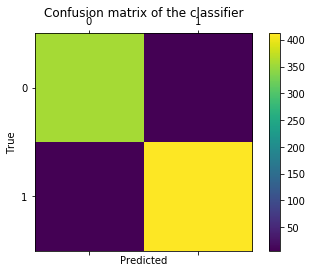

In [12]:
labels = [0, 1]
cm = confusion_matrix(gt, jh, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

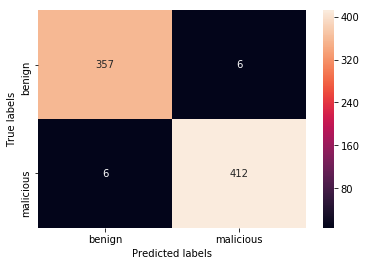

In [13]:
import seaborn as sns
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
#ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['benign', 'malicious']); ax.yaxis.set_ticklabels(['benign', 'malicious']);
ax.figure.savefig('ConfusionMatrix.eps', format='eps')
